# FinBERT Model Training

This notebook implements the training pipeline for FinBERT model on our financial tweets dataset.

## Pipeline Overview:
1. Load labeled data
2. Preprocess text
3. Configure and initialize FinBERT
4. Train model with evaluation
5. Save model and metrics

In [7]:
!pip install pandas numpy scikit-learn torch transformers matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Load and Prepare Data

In [9]:
def load_labeled_data(file_path):
    """Load Gemini-labeled dataset"""
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} labeled tweets")
    return df

# Load the labeled data
df = load_labeled_data('../data/all_labeled_tweets.csv')
df.head()

Loaded 28172 labeled tweets


,image_url,proxy_image_url,image_dimensions,thumbnail_url,proxy_thumbnail_url,thumbnail_dimensions,timestamp,description,url,embed_title,tweet_type,financial_info,sentiment
0,https://pbs.twimg.com/media/F-78hiZXMAAt4NV.jpg,https://images-ext-1.discordapp.net/external/r...,"(749, 1085)",https://pbs.twimg.com/profile_images/131943349...,https://images-ext-1.discordapp.net/external/h...,"(48, 48)",2023-11-15T01:06:39.739000+00:00,Currently at $2860--Documenting everything in ...,https://twitter.com/user/status/17245942794969...,<:quote_tweet:1130467736133316700> Albertrays ...,quote tweet,"[{'ticker': '$AI', 'exchanges': [], 'price': '...",NEUTRAL
1,https://pbs.twimg.com/media/F-8MPdNXAAAu6m1.jpg,https://images-ext-1.discordapp.net/external/N...,"(653, 1199)",https://pbs.twimg.com/profile_images/164958768...,https://images-ext-1.discordapp.net/external/l...,"(48, 48)",2023-11-15T02:11:41.182000+00:00,$NET \n\nWas waiting on Cloudflare and it erup...,https://twitter.com/user/status/17246106454321...,Don't follow Shardi B If You Hate Money tweete...,tweet,"[{'ticker': '$NET', 'exchanges': [], 'price': ...",NEUTRAL
2,https://pbs.twimg.com/media/F-7TGF8aMAAIDdp.png,https://images-ext-1.discordapp.net/external/I...,"(1200, 591)",https://pbs.twimg.com/profile_images/150099051...,https://images-ext-1.discordapp.net/external/j...,"(48, 48)",2023-11-15T02:11:47.180000+00:00,"RT @TrendSpider: $SPY, $QQQ and $AAPL all prin...",https://twitter.com/user/status/17246108137746...,<:retweet:1130467740306657360> Theta Warrior r...,retweet,"[{'ticker': '$QQQ', 'exchanges': [], 'price': ...",NEUTRAL
3,https://pbs.twimg.com/media/F-8RX54WEAA7Mn4.jpg,https://images-ext-1.discordapp.net/external/J...,"(1200, 653)",https://pbs.twimg.com/profile_images/150561647...,https://images-ext-1.discordapp.net/external/F...,"(48, 48)",2023-11-15T04:01:40.263000+00:00,RT @TriggerTrades: $SPX remained above 4375 th...,https://twitter.com/user/status/17246376379723...,<:retweet:1130467740306657360> ReciKnows retwe...,retweet,"[{'ticker': '$SPX', 'exchanges': [], 'price': ...",NEUTRAL
4,https://pbs.twimg.com/media/F-8j7aHWIAA9tSn.png,https://images-ext-1.discordapp.net/external/x...,"(884, 665)",https://pbs.twimg.com/profile_images/150561647...,https://images-ext-1.discordapp.net/external/F...,"(48, 48)",2023-11-15T04:01:44.817000+00:00,RT @coiledspringcap: #SPX equal weight breakin...,https://twitter.com/user/status/17246376783927...,<:retweet:1130467740306657360> ReciKnows retwe...,retweet,"[{'ticker': '$SPX', 'exchanges': [], 'price': ...",NEUTRAL


## 2. Adopt to 5 label

In [10]:
# Map sentiment labels to numeric values (0-4)
sentiment_mapping = {
    'STRONGLY_NEGATIVE': 0,
    'NEGATIVE': 1,
    'NEUTRAL': 2,
    'POSITIVE': 3,
    'STRONGLY_POSITIVE': 4
}

# Create a new column with numeric labels
df['label'] = df['sentiment'].map(lambda x: sentiment_mapping.get(x, 2))  # Default to NEUTRAL if not found

# Check the distribution of labels
print("Label distribution:")
print(df['sentiment'].value_counts())
print(df['label'].value_counts())

Label distribution:
sentiment
NEUTRAL              20803
NEGATIVE              3700
POSITIVE              2687
STRONGLY_POSITIVE      630
STRONGLY_NEGATIVE      352
Name: count, dtype: int64
label
2    20803
1     3700
3     2687
4      630
0      352
Name: count, dtype: int64


## 3. Create Dataset and DataLoader

In [11]:
class FinancialTweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['description'].values, df['label'].values, 
    test_size=0.2, random_state=42
)

# Initialize tokenizer (using FinBERT)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

# Create datasets
train_dataset = FinancialTweetDataset(train_texts, train_labels, tokenizer)
val_dataset = FinancialTweetDataset(val_texts, val_labels, tokenizer)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 22537
Validation samples: 5635


## 4. Model Configuration and Training

In [12]:
def compute_metrics(eval_pred):
    """Calculate evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    'ProsusAI/finbert',
    num_labels=5,  # 5 labels: STRONGLY_NEGATIVE, NEGATIVE, NEUTRAL, POSITIVE, STRONGLY_POSITIVE
    ignore_mismatched_sizes=True  # This parameter allows loading with mismatched classification layer
)

# Training arguments
training_args = TrainingArguments(
    output_dir='./finbert_results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./finbert_logs',
    logging_steps=10,
    eval_strategy="steps",        # Use steps-based evaluation
    save_strategy="steps",        # Use steps-based saving
    eval_steps=250,               # Evaluate every 250 steps
    save_steps=250,               # Save checkpoint every 250 steps
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,0.842300,0.787828,0.730790,0.534054,0.730790,0.617121
500,0.644100,0.667251,0.736823,0.686237,0.736823,0.703770
750,0.659100,0.625127,0.750133,0.722092,0.750133,0.727234
1000,0.634100,0.611146,0.753150,0.724959,0.753150,0.709999
1250,0.529100,0.615728,0.753150,0.721121,0.753150,0.720000
1500,0.551900,0.613329,0.746051,0.743280,0.746051,0.743123
1750,0.517100,0.634651,0.735936,0.759063,0.735936,0.738756
2000,0.482000,0.608714,0.751375,0.727045,0.751375,0.729842
2250,0.576200,0.608764,0.747649,0.750706,0.747649,0.745799
2500,0.515600,0.609658,0.747826,0.754513,0.747826,0.750192


/Users/jethrotsoi/anaconda3/envs/PIRAS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jethrotsoi/anaconda3/envs/PIRAS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jethrotsoi/anaconda3/envs/PIRAS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

TrainOutput(global_step=3500, training_loss=0.5465800493104117, metrics={'train_runtime': 2912.3505, 'train_samples_per_second': 38.692, 'train_steps_per_second': 2.419, 'total_flos': 3682733080997376.0, 'train_loss': 0.5465800493104117, 'epoch': 2.48403122782115})

## 5. Model Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.24      0.29        76
           1       0.54      0.57      0.56       749
           2       0.83      0.87      0.85      4118
           3       0.56      0.43      0.49       569
           4       0.45      0.28      0.34       123

    accuracy                           0.76      5635
   macro avg       0.55      0.48      0.51      5635
weighted avg       0.75      0.76      0.76      5635



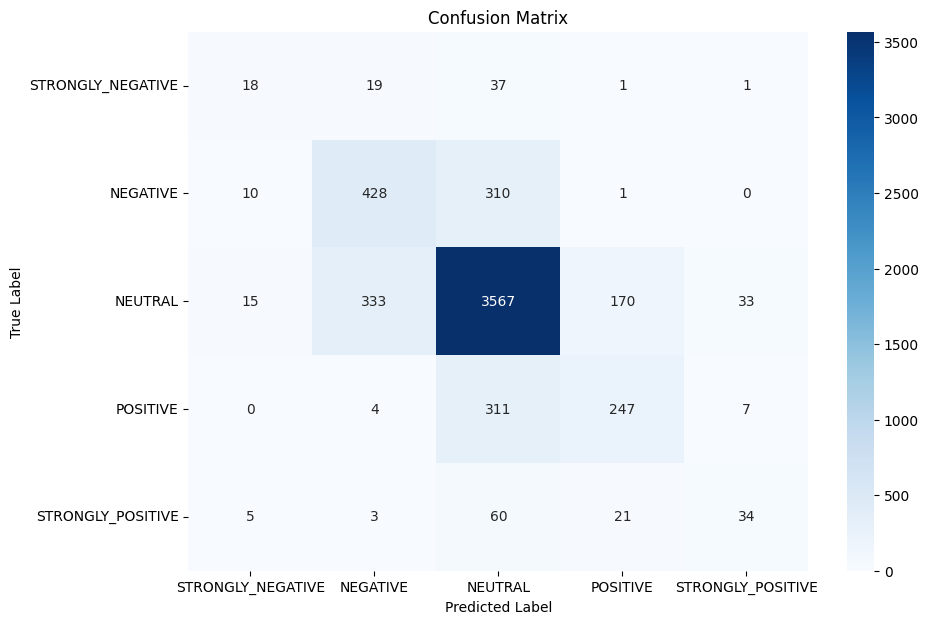

In [13]:
def plot_confusion_matrix(cm, classes):
    """Plot confusion matrix using seaborn"""
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get predictions
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Calculate and display metrics
print("\nClassification Report:")
print(classification_report(val_labels, preds))

# Plot confusion matrix
cm = confusion_matrix(val_labels, preds)
plot_confusion_matrix(cm, classes=['STRONGLY_NEGATIVE', 'NEGATIVE', 'NEUTRAL', 'POSITIVE', 'STRONGLY_POSITIVE'])

## 6. Save Model and Results

In [14]:
# Save the model
output_dir = '../models/finbert'
os.makedirs(output_dir, exist_ok=True)
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

# Save evaluation metrics
eval_metrics = compute_metrics((predictions.predictions, val_labels))
metrics_df = pd.DataFrame([eval_metrics])
metrics_df.to_csv(f'{output_dir}/metrics.csv', index=False)

print("\nFinal Evaluation Metrics:")
for metric, value in eval_metrics.items():
    print(f"{metric}: {value:.4f}")


Final Evaluation Metrics:
accuracy: 0.7620
precision: 0.7523
recall: 0.7620
f1: 0.7554
